Improved at step 1: best = 683


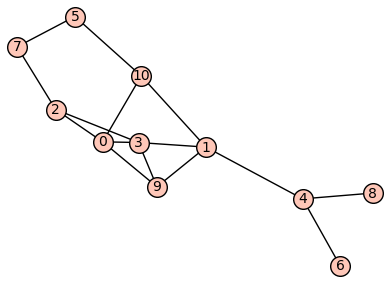

Improved at step 3: best = 770


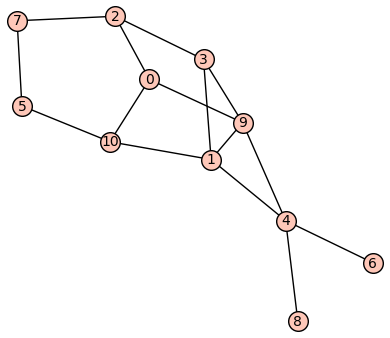

Improved at step 4: best = 942


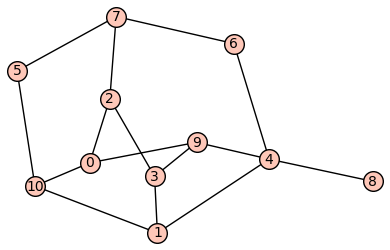

Improved at step 54: best = 948


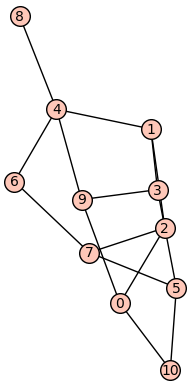

Improved at step 66: best = 978


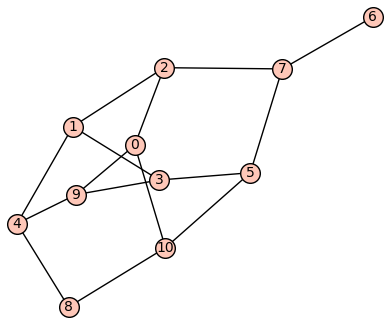

Improved at step 78: best = 991


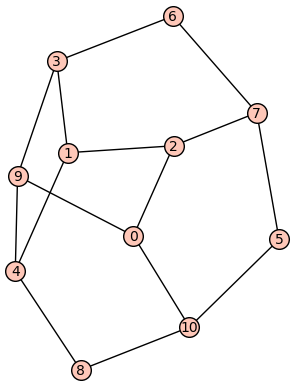

Improved at step 164: best = 998


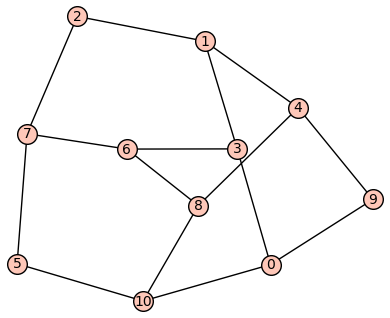

Improved at step 195: best = 1003


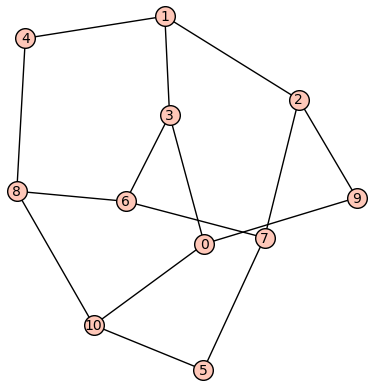

Improved at step 784: best = 1005


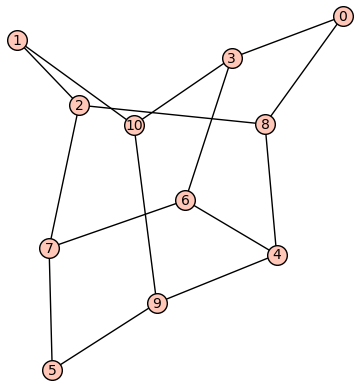

Best: 1005


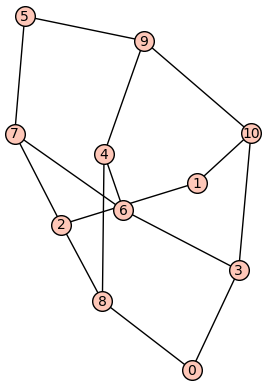

Ali je PTC graf False


In [22]:
import random as pyrandom
from sage.all import *

# ============================================================
#   Helper: all simple paths + subpath number
# ============================================================

def all_simple_paths(G, start, end, visited=None):
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for nei in G.neighbors(start):
        if nei not in visited:
            newp = all_simple_paths(G, nei, end, visited)
            paths.extend(newp)
    return paths

def subpath_number(G):
    V = G.vertices()
    total = 0
    for i in range(len(V)):
        for j in range(i, len(V)):
            total += len(all_simple_paths(G, V[i], V[j]))
    return total

# ============================================================
#   Mutacija grafa
# ============================================================

def mutate_graph(G):
    H = G.copy()

    edges = list(H.edges())
    non_edges = [(u, v) for u in H.vertices()
                 for v in H.vertices()
                 if u < v and not H.has_edge(u, v)]

    if not edges or not non_edges:
        return H

    e_remove = pyrandom.choice(edges)
    H.delete_edge(e_remove)

    e_add = pyrandom.choice(non_edges)
    H.add_edge(e_add)

    if not H.is_connected():
        return G

    return H

# ============================================================
#   Naključni povezan graf G(n, m)
# ============================================================

def random_connected_graph(n, m):
    while True:
        G = graphs.RandomGNM(n, m)
        if G.is_connected():
            return G

# ============================================================
#   Preverjanje PTC
# ============================================================
def is_ptc(G):
    # mora biti povezan
    if not G.is_connected():
        return False

    # blok-komponente in presečišča
    blocks, cut_vertices = G.blocks_and_cut_vertices()

    # shranimo samo nenetrivialne bloke (vsaj 2 vozlišči)
    nontrivial_blocks = [Bl for Bl in blocks if len(Bl) >= 2]
    B = len(nontrivial_blocks)

    if B < 2:
        return False

    # 1) vsak nenetrivialen blok mora biti trikotnik (C3)
    triangular_idx = []
    for i, Bl in enumerate(nontrivial_blocks):
        sub = G.subgraph(Bl)
        if sub.order() == 3 and sub.size() == 3:
            triangular_idx.append(i)
        else:
            # če je kakšen blok, ki ni trikotnik, ni PTC
            return False

    k = len(triangular_idx)
    if k < 2:
        return False

    # 2) zgradimo block-graf med trikotniki
    adj = {i: [] for i in triangular_idx}

    for i in triangular_idx:
        for j in triangular_idx:
            if j <= i:
                continue
            inter = set(nontrivial_blocks[i]).intersection(nontrivial_blocks[j])
            if len(inter) > 1:
                # dva trikotnika ne smeta deliti več kot enega vozlišča
                return False
            if len(inter) == 1:
                adj[i].append(j)
                adj[j].append(i)

    # 3) preverimo, da je block-graf pot: stopnje ≤2,
    #    točno dva trikotnika stopnje 1, ostali stopnje 2
    degrees = [len(adj[i]) for i in triangular_idx]

    if any(d == 0 or d > 2 for d in degrees):
        return False

    ends = sum(1 for d in degrees if d == 1)
    mids = sum(1 for d in degrees if d == 2)

    if ends != 2:
        return False
    if ends + mids != k:
        return False

    # 4) preverimo še povezavnost med trikotniki (da je res ena sama veriga)
    # BFS po block-grafu
    start = triangular_idx[0]
    visited = set([start])
    stack = [start]

    while stack:
        v = stack.pop()
        for w in adj[v]:
            if w not in visited:
                visited.add(w)
                stack.append(w)

    if len(visited) != k:
        return False

    return True


# ============================================================
#   Simulated annealing + STOP WHEN PTC FOUND
# ============================================================

def simulated_annealing(n, m, direction,
                        T_start=5.0, T_end=0.01,
                        cooling=0.999, max_steps=5000):

    # začetni graf
    G = random_connected_graph(n, m)

    best_G = G.copy()
    best_score = subpath_number(G)

    current_G = G.copy()
    current_score = best_score

    T = T_start

    for step in range(max_steps):

        new_G = mutate_graph(current_G)
        new_score = subpath_number(new_G)

        # izračun delte
        if direction == "min":
            delta = new_score - current_score
        else:  # direction == "max"
            delta = current_score - new_score

        # SA sprejem
        if delta < 0:
            current_G = new_G
            current_score = new_score
        else:
            if pyrandom.random() < exp(-delta / T):
                current_G = new_G
                current_score = new_score

        # ===========================
        #   PREVERJANJE IZBOLJŠAVE
        # ===========================
        improved = False

        if direction == "min":
            if current_score < best_score:
                improved = True
        else: # direction == "max"
            if current_score > best_score:
                improved = True

        if improved:
            best_score = current_score
            best_G = current_G.copy()

            print(f"Improved at step {step}: best = {best_score}")
            best_G.show()

            # -------------------------------
            #   PTC STOP CONDITION (MIN ONLY)
            # -------------------------------
            if direction == "min" and is_ptc(best_G):
                print("PTC FOUND → stopping SA early!")
                return best_G, best_score

        # hlajenje
        T *= cooling
        if T < T_end:
            break

    return best_G, best_score

# ============================================================
#   TEST
# ============================================================

n = 11
m = 15
direction = "max"

best_graph, best_value = simulated_annealing(n, m, direction)
print("Best:", best_value)
best_graph.show()
print("Ali je PTC graf", is_ptc(best_graph))
